<a href="https://colab.research.google.com/github/hbdMahsa/fdfd/blob/main/seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
!pip install -q pytorch-lightning
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 11.9 MB/s eta 0:00:00


In [ ]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    NormalizeIntensityd,
    ScaleIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)

from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

print_config()

In [3]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task02_Heart.tar"
root_dir = "/content/"
compressed_file = os.path.join(root_dir, "Task02_Heart.tar")
data_dir = os.path.join(root_dir, "Task02_Heart")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir)

Task02_Heart.tar: 435MB [00:40, 11.2MB/s]                           

2023-10-26 03:11:22,039 - INFO - Downloaded: /content/Task02_Heart/Task02_Heart.tar
2023-10-26 03:11:22,043 - INFO - Expected md5 is None, skip md5 check for file /content/Task02_Heart/Task02_Heart.tar.
2023-10-26 03:11:22,047 - INFO - Writing into directory: /content/Task02_Heart.


In [4]:
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-3], data_dicts[-3:]

In [20]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        #NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
        #ScaleIntensityd(keys=["image"]),
        #CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        #Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        #RandCropByPosNegLabeld(
        #    keys=["image", "label"],
        #    label_key="label",
        #    spatial_size=(96, 96, 96),
        #    pos=1,
        #    neg=1,
        #    num_samples=4,
        #    image_key="image",
        #    image_threshold=0,
        #),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        #ScaleIntensityd(keys=["image"]),
        ##CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        #Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

In [21]:
check_ds = Dataset(data=val_files, transform=val_transforms)

In [23]:
check_ds[0]["image"][0].shape

torch.Size([320, 320, 120])

image shape: torch.Size([320, 320, 120]), label shape: torch.Size([320, 320, 120])


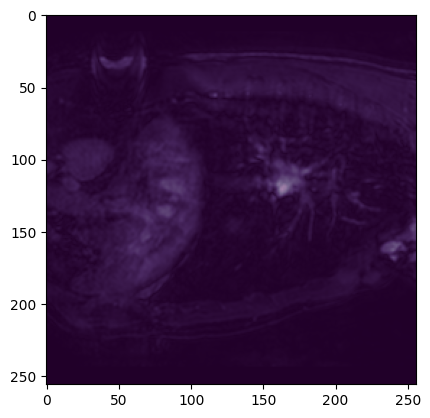

In [45]:
from celluloid import Camera
import numpy as np
from IPython.display import HTML
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")

fig = plt.figure()
camera = Camera(fig)

for i in range(image.shape[2]):
    plt.imshow(image[32:-32,32:-32,i], cmap='bone')
    mask_ = np.ma.masked_where(label[:,:,i] == 0, label[:,:,i])
    plt.imshow(label[32:-32,32:-32,i], alpha=0.5)
    camera.snap()

In [46]:
HTML(camera.animate().to_html5_video())

image shape: torch.Size([320, 320, 120]), label shape: torch.Size([320, 320, 120])


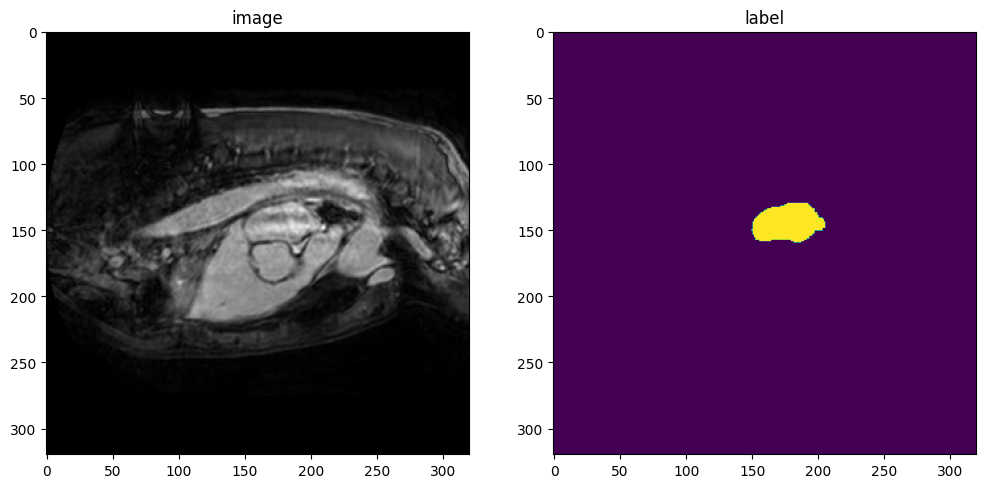

In [34]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
slc = 70
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, slc], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, slc])
plt.show()